In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


In [6]:
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('')


In [8]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)


3670


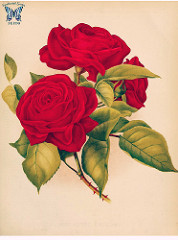

In [4]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))


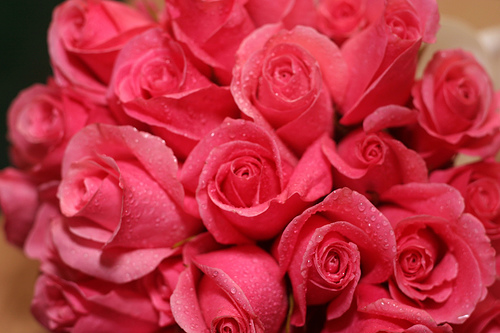

In [6]:
PIL.Image.open(str(roses[1]))
#print(len(roses))

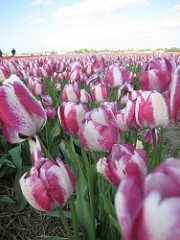

In [7]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))


In [9]:
#Create a dataset
batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [17]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [10]:
class_names = train_ds.class_names
print(class_names)


['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


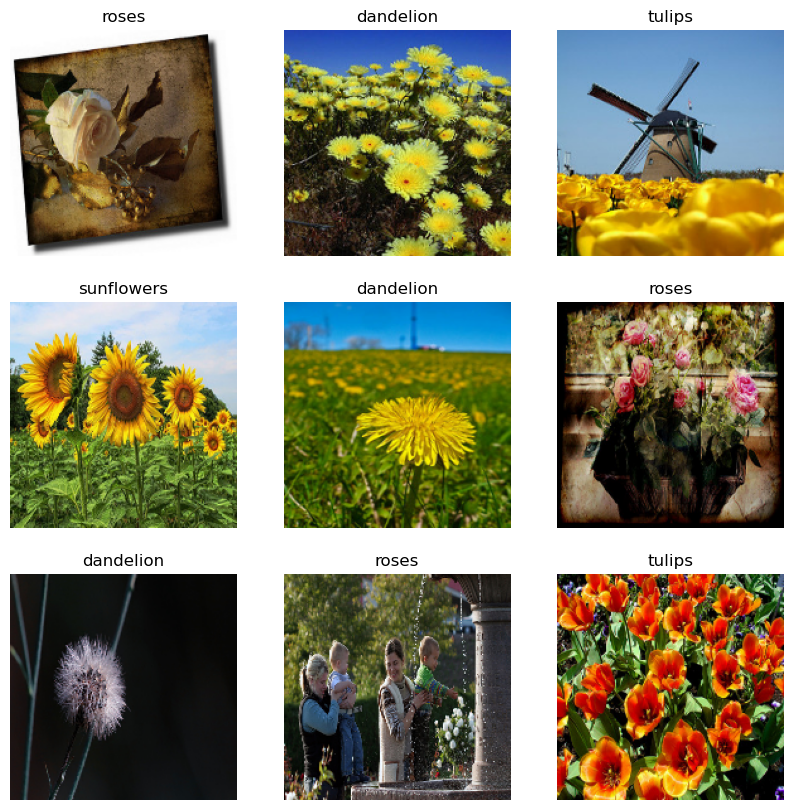

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [12]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 180, 180, 3)
(32,)


In [13]:
print(type(image_batch))
im_bat_array = image_batch.numpy()
lab_bat_array = labels_batch.numpy()
print(len(im_bat_array))
print(type(im_bat_array))
print(im_bat_array.shape)

<class 'tensorflow.python.framework.ops.EagerTensor'>
32
<class 'numpy.ndarray'>
(32, 180, 180, 3)


In [14]:
print(class_names[3])
print(lab_bat_array[3])
print(class_names[lab_bat_array[3]])

sunflowers
4
tulips


In [18]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [19]:
normalization_layer = layers.Rescaling(1./255)


In [20]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))


0.0 1.0


In [21]:
# A basic Keras model
## Create the model
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


2023-12-28 17:32:48.325111: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 15859712 exceeds 10% of free system memory.
2023-12-28 17:32:48.365464: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 15859712 exceeds 10% of free system memory.
2023-12-28 17:32:48.374646: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 15859712 exceeds 10% of free system memory.


In [22]:
## Compile the model

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [23]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [24]:
## Train the model
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/10


2023-12-28 17:33:13.588361: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 15859712 exceeds 10% of free system memory.
2023-12-28 17:33:13.606134: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 15859712 exceeds 10% of free system memory.


92/92 [==============================] - 139s 1s/step - loss: 1.3893 - accuracy: 0.4022 - val_loss: 1.0584 - val_accuracy: 0.5681
Epoch 2/10
92/92 [==============================] - 114s 1s/step - loss: 1.0070 - accuracy: 0.6100 - val_loss: 0.9386 - val_accuracy: 0.6090
Epoch 3/10
92/92 [==============================] - 110s 1s/step - loss: 0.8430 - accuracy: 0.6683 - val_loss: 0.8884 - val_accuracy: 0.6322
Epoch 4/10
92/92 [==============================] - 143s 2s/step - loss: 0.6429 - accuracy: 0.7599 - val_loss: 0.8602 - val_accuracy: 0.6580
Epoch 5/10
92/92 [==============================] - 113s 1s/step - loss: 0.4413 - accuracy: 0.8379 - val_loss: 1.0161 - val_accuracy: 0.6471
Epoch 6/10
92/92 [==============================] - 117s 1s/step - loss: 0.2478 - accuracy: 0.9094 - val_loss: 1.1511 - val_accuracy: 0.6553
Epoch 7/10
92/92 [==============================] - 142s 2s/step - loss: 0.1530 - accuracy: 0.9503 - val_loss: 1.3596 - val_accuracy: 0.6540
Epoch 8/10
92/92 [======

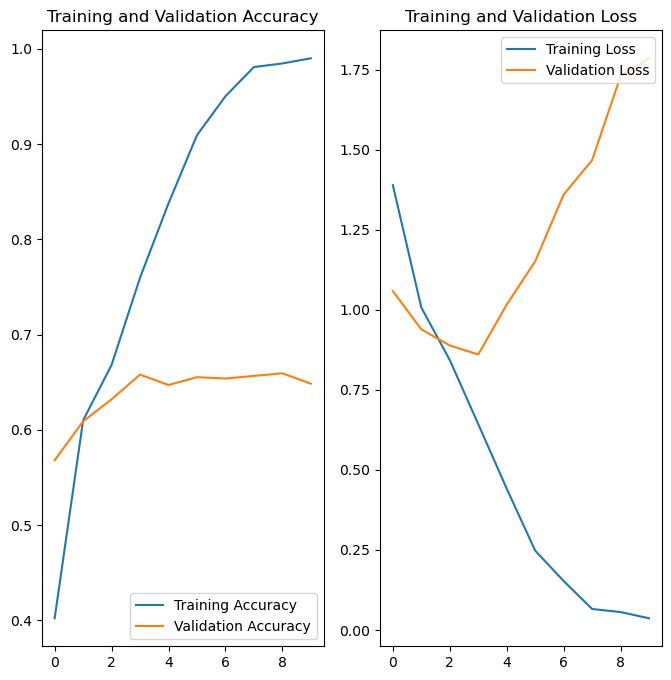

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [26]:
# Reducing over fitting
## Data augmentation
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)


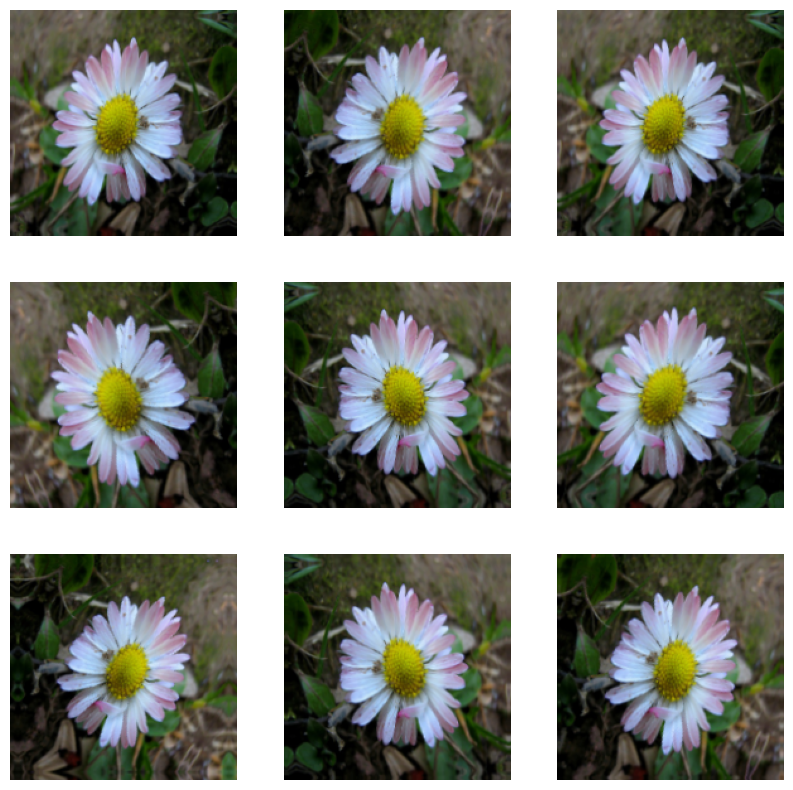

In [27]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


In [28]:
## Dropout
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])


In [29]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [45]:
model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [30]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/15
92/92 [==============================] - 160s 2s/step - loss: 1.3246 - accuracy: 0.4298 - val_loss: 1.0854 - val_accuracy: 0.5436
Epoch 2/15
92/92 [==============================] - 155s 2s/step - loss: 1.0855 - accuracy: 0.5661 - val_loss: 1.0809 - val_accuracy: 0.5763
Epoch 3/15
92/92 [==============================] - 151s 2s/step - loss: 0.9721 - accuracy: 0.6141 - val_loss: 0.9383 - val_accuracy: 0.6403
Epoch 4/15
92/92 [==============================] - 151s 2s/step - loss: 0.8990 - accuracy: 0.6591 - val_loss: 0.8443 - val_accuracy: 0.6635
Epoch 5/15
92/92 [==============================] - 146s 2s/step - loss: 0.8360 - accuracy: 0.6785 - val_loss: 0.9440 - val_accuracy: 0.6376
Epoch 6/15
92/92 [==============================] - 145s 2s/step - loss: 0.7951 - accuracy: 0.6870 - val_loss: 0.7609 - val_accuracy: 0.6948
Epoch 7/15
92/92 [==============================] - 145s 2s/step - loss: 0.7556 - accuracy: 0.7142 - val_loss: 0.7517 - val_accuracy: 0.7193
Epoch 8/15
92

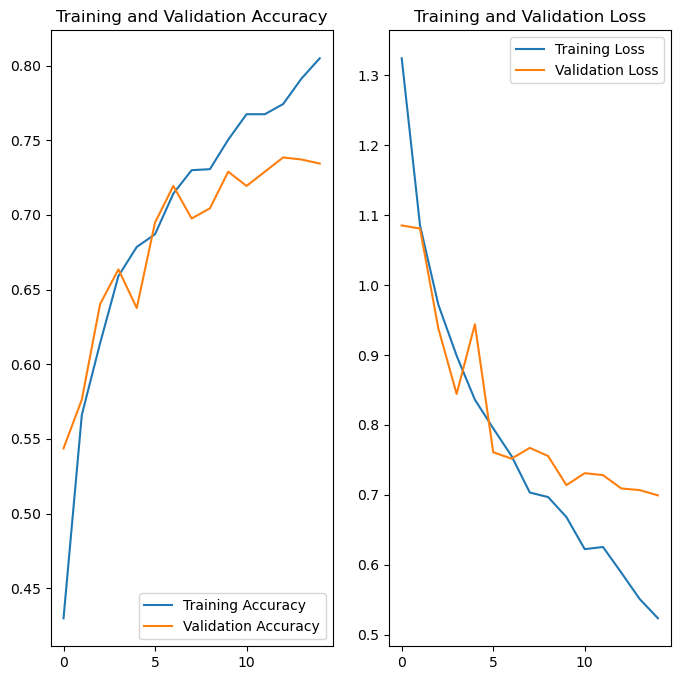

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [35]:
# Predict on new data
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


This image most likely belongs to sunflowers with a 97.95 percent confidence.


In [40]:
# Use TensorFlow Lite
## Convert the Keras Sequential model to a TensorFlow Lite model
# this does not work! I suspect I need a GPU
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)


2023-12-28 20:26:21.598725: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2023-12-28 20:26:21.598880: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-12-28 20:26:21.617389: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:1149] Optimization results for grappler item: graph_to_optimize
  function_optimizer: function_optimizer did nothing. time = 0.36ms.
  function_optimizer: function_optimizer did nothing. time = 0.007ms.

2023-12-28 20:26:21.977999: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:363] Ignored output_format.
2023-12-28 20:26:21.978049: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:366] Ignored drop_control_dependency.


In [42]:
# Run the TensorFlow Lite model

TF_MODEL_FILE_PATH = 'model.tflite' # The default path to the saved TensorFlow Lite model

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

interpreter.get_signature_list()



{}

In [43]:
classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite


ValueError: Invalid signature_key provided.